In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder

In [2]:
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except FileNotFoundError:
            # If file is not found, return a dummy image and a dummy label
            dummy_img = Image.new('RGB', (128, 128))
            return self.transform(dummy_img), -1  # Use a label that indicates missing file


In [3]:

# Define the transformations for the training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
}

# Specify the dataset directory paths
train_dir = r'C:\Users\User\Desktop\Tomato_disease\Datasets\tomato\train'
val_dir = r'C:\Users\User\Desktop\Tomato_disease\Datasets\tomato\val'

# Load the datasets using the SafeImageFolder class
train_dataset = SafeImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = SafeImageFolder(val_dir, transform=data_transforms['val'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [4]:
# Define CNN architecture 
class ImprovedPlantVillageCNN(nn.Module):
    def __init__(self):
        super(ImprovedPlantVillageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedPlantVillageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if (labels == -1).all():  # Skip batches with only dummy data
                continue
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
            pbar.update(1)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_correct / running_total)

    # Validate the model every epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validating', unit='batch') as pbar_val:
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                if (labels == -1).all():  # Skip batches with only dummy data
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                pbar_val.update(1)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')





Validating: 100%|██████████| 16/16 [00:05<00:00,  3.03batch/s]


Epoch [1/100], Train Loss: 1.5314, Val Loss: 1.4377, Train Accuracy: 0.5765, Val Accuracy: 0.6140


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.75batch/s]


Epoch [2/100], Train Loss: 0.6844, Val Loss: 1.3545, Train Accuracy: 0.7656, Val Accuracy: 0.6170


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.63batch/s]


Epoch [3/100], Train Loss: 0.5711, Val Loss: 0.6655, Train Accuracy: 0.8012, Val Accuracy: 0.7720


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.33batch/s]


Epoch [4/100], Train Loss: 0.4978, Val Loss: 0.4797, Train Accuracy: 0.8293, Val Accuracy: 0.8380


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.40batch/s]


Epoch [5/100], Train Loss: 0.4348, Val Loss: 0.5235, Train Accuracy: 0.8515, Val Accuracy: 0.8480


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.84batch/s]


Epoch [6/100], Train Loss: 0.3866, Val Loss: 0.4951, Train Accuracy: 0.8676, Val Accuracy: 0.8380


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.07batch/s]


Epoch [7/100], Train Loss: 0.3455, Val Loss: 4.0697, Train Accuracy: 0.8822, Val Accuracy: 0.4270


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.91batch/s]


Epoch [8/100], Train Loss: 0.3209, Val Loss: 0.2251, Train Accuracy: 0.8887, Val Accuracy: 0.9290


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.70batch/s]


Epoch [9/100], Train Loss: 0.3021, Val Loss: 0.3265, Train Accuracy: 0.8964, Val Accuracy: 0.9120


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.18batch/s]


Epoch [10/100], Train Loss: 0.2863, Val Loss: 0.2254, Train Accuracy: 0.9021, Val Accuracy: 0.9340


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.70batch/s]


Epoch [11/100], Train Loss: 0.2859, Val Loss: 1.2170, Train Accuracy: 0.9029, Val Accuracy: 0.7490


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.04batch/s]


Epoch [12/100], Train Loss: 0.2498, Val Loss: 0.3871, Train Accuracy: 0.9116, Val Accuracy: 0.8900


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.79batch/s]


Epoch [13/100], Train Loss: 0.2386, Val Loss: 1.0068, Train Accuracy: 0.9177, Val Accuracy: 0.7640


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.12batch/s]


Epoch [14/100], Train Loss: 0.2322, Val Loss: 0.9006, Train Accuracy: 0.9216, Val Accuracy: 0.7690


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.12batch/s]


Epoch [15/100], Train Loss: 0.2318, Val Loss: 0.2694, Train Accuracy: 0.9200, Val Accuracy: 0.9200


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [16/100], Train Loss: 0.2217, Val Loss: 0.3240, Train Accuracy: 0.9203, Val Accuracy: 0.9020


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.68batch/s]


Epoch [17/100], Train Loss: 0.1805, Val Loss: 0.3429, Train Accuracy: 0.9353, Val Accuracy: 0.9040


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.78batch/s]


Epoch [18/100], Train Loss: 0.1934, Val Loss: 0.5573, Train Accuracy: 0.9322, Val Accuracy: 0.8570


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.98batch/s]


Epoch [19/100], Train Loss: 0.1673, Val Loss: 0.2587, Train Accuracy: 0.9431, Val Accuracy: 0.9170


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.93batch/s]


Epoch [20/100], Train Loss: 0.1689, Val Loss: 2.4167, Train Accuracy: 0.9424, Val Accuracy: 0.6600


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.38batch/s]


Epoch [21/100], Train Loss: 0.1739, Val Loss: 0.7602, Train Accuracy: 0.9388, Val Accuracy: 0.8450


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.53batch/s]


Epoch [22/100], Train Loss: 0.1381, Val Loss: 0.1893, Train Accuracy: 0.9527, Val Accuracy: 0.9430


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.81batch/s]


Epoch [23/100], Train Loss: 0.1656, Val Loss: 0.3978, Train Accuracy: 0.9426, Val Accuracy: 0.9080


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [24/100], Train Loss: 0.1346, Val Loss: 0.2029, Train Accuracy: 0.9534, Val Accuracy: 0.9500


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.91batch/s]


Epoch [25/100], Train Loss: 0.1354, Val Loss: 1.5202, Train Accuracy: 0.9529, Val Accuracy: 0.7100


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.90batch/s]


Epoch [26/100], Train Loss: 0.1164, Val Loss: 0.6081, Train Accuracy: 0.9601, Val Accuracy: 0.8670


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.93batch/s]


Epoch [27/100], Train Loss: 0.1136, Val Loss: 0.4350, Train Accuracy: 0.9604, Val Accuracy: 0.8840


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.53batch/s]


Epoch [28/100], Train Loss: 0.1128, Val Loss: 0.8230, Train Accuracy: 0.9633, Val Accuracy: 0.8050


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.29batch/s]


Epoch [29/100], Train Loss: 0.1093, Val Loss: 0.5594, Train Accuracy: 0.9621, Val Accuracy: 0.8740


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.50batch/s]


Epoch [30/100], Train Loss: 0.1019, Val Loss: 0.7546, Train Accuracy: 0.9631, Val Accuracy: 0.8740


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.91batch/s]


Epoch [31/100], Train Loss: 0.1067, Val Loss: 0.2256, Train Accuracy: 0.9631, Val Accuracy: 0.9410


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.38batch/s]


Epoch [32/100], Train Loss: 0.1071, Val Loss: 0.2696, Train Accuracy: 0.9643, Val Accuracy: 0.9310


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.79batch/s]


Epoch [33/100], Train Loss: 0.1034, Val Loss: 0.7573, Train Accuracy: 0.9652, Val Accuracy: 0.8750


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [34/100], Train Loss: 0.1096, Val Loss: 0.3822, Train Accuracy: 0.9618, Val Accuracy: 0.9240


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.90batch/s]


Epoch [35/100], Train Loss: 0.0850, Val Loss: 0.6943, Train Accuracy: 0.9709, Val Accuracy: 0.8670


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.53batch/s]


Epoch [36/100], Train Loss: 0.0700, Val Loss: 0.4083, Train Accuracy: 0.9748, Val Accuracy: 0.9190


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.12batch/s]


Epoch [37/100], Train Loss: 0.0934, Val Loss: 0.2269, Train Accuracy: 0.9680, Val Accuracy: 0.9450


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [38/100], Train Loss: 0.0763, Val Loss: 2.3485, Train Accuracy: 0.9733, Val Accuracy: 0.7270


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.91batch/s]


Epoch [39/100], Train Loss: 0.1203, Val Loss: 1.3191, Train Accuracy: 0.9614, Val Accuracy: 0.7830


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.87batch/s]


Epoch [40/100], Train Loss: 0.0654, Val Loss: 3.4375, Train Accuracy: 0.9781, Val Accuracy: 0.6830


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.51batch/s]


Epoch [41/100], Train Loss: 0.0765, Val Loss: 0.7831, Train Accuracy: 0.9745, Val Accuracy: 0.8570


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.73batch/s]


Epoch [42/100], Train Loss: 0.0807, Val Loss: 0.2619, Train Accuracy: 0.9738, Val Accuracy: 0.9430


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.33batch/s]


Epoch [43/100], Train Loss: 0.0648, Val Loss: 0.3592, Train Accuracy: 0.9776, Val Accuracy: 0.9380


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.63batch/s]


Epoch [44/100], Train Loss: 0.0736, Val Loss: 0.2114, Train Accuracy: 0.9751, Val Accuracy: 0.9550


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.52batch/s]


Epoch [45/100], Train Loss: 0.0744, Val Loss: 0.3433, Train Accuracy: 0.9745, Val Accuracy: 0.9370


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [46/100], Train Loss: 0.0666, Val Loss: 0.4988, Train Accuracy: 0.9769, Val Accuracy: 0.9050


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [47/100], Train Loss: 0.0578, Val Loss: 1.2876, Train Accuracy: 0.9803, Val Accuracy: 0.8470


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.59batch/s]


Epoch [48/100], Train Loss: 0.0763, Val Loss: 0.5890, Train Accuracy: 0.9747, Val Accuracy: 0.8920


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.48batch/s]


Epoch [49/100], Train Loss: 0.0586, Val Loss: 0.8885, Train Accuracy: 0.9801, Val Accuracy: 0.8840


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.24batch/s]


Epoch [50/100], Train Loss: 0.0635, Val Loss: 0.3321, Train Accuracy: 0.9781, Val Accuracy: 0.9320


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [51/100], Train Loss: 0.0563, Val Loss: 0.2799, Train Accuracy: 0.9820, Val Accuracy: 0.9440


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.65batch/s]


Epoch [52/100], Train Loss: 0.0543, Val Loss: 0.9286, Train Accuracy: 0.9817, Val Accuracy: 0.8850


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.41batch/s]


Epoch [53/100], Train Loss: 0.0764, Val Loss: 0.1615, Train Accuracy: 0.9763, Val Accuracy: 0.9630


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.42batch/s]


Epoch [54/100], Train Loss: 0.0562, Val Loss: 0.3350, Train Accuracy: 0.9816, Val Accuracy: 0.9290


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.30batch/s]


Epoch [55/100], Train Loss: 0.0458, Val Loss: 0.6726, Train Accuracy: 0.9840, Val Accuracy: 0.8950


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.32batch/s]


Epoch [56/100], Train Loss: 0.0549, Val Loss: 0.9285, Train Accuracy: 0.9810, Val Accuracy: 0.8450


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.78batch/s]


Epoch [57/100], Train Loss: 0.0561, Val Loss: 0.3927, Train Accuracy: 0.9789, Val Accuracy: 0.9350


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.61batch/s]


Epoch [58/100], Train Loss: 0.0617, Val Loss: 0.4892, Train Accuracy: 0.9829, Val Accuracy: 0.9260


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.47batch/s]


Epoch [59/100], Train Loss: 0.0591, Val Loss: 1.1263, Train Accuracy: 0.9797, Val Accuracy: 0.8620


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.81batch/s]


Epoch [60/100], Train Loss: 0.0352, Val Loss: 0.1874, Train Accuracy: 0.9887, Val Accuracy: 0.9660


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.63batch/s]


Epoch [61/100], Train Loss: 0.0688, Val Loss: 0.5017, Train Accuracy: 0.9778, Val Accuracy: 0.9140


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.43batch/s]


Epoch [62/100], Train Loss: 0.0337, Val Loss: 0.4849, Train Accuracy: 0.9873, Val Accuracy: 0.9090


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.96batch/s]


Epoch [63/100], Train Loss: 0.0441, Val Loss: 1.8079, Train Accuracy: 0.9840, Val Accuracy: 0.7880


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.59batch/s]


Epoch [64/100], Train Loss: 0.0451, Val Loss: 0.2033, Train Accuracy: 0.9852, Val Accuracy: 0.9600


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.84batch/s]


Epoch [65/100], Train Loss: 0.0742, Val Loss: 0.1976, Train Accuracy: 0.9772, Val Accuracy: 0.9580


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.38batch/s]


Epoch [66/100], Train Loss: 0.0362, Val Loss: 1.4448, Train Accuracy: 0.9873, Val Accuracy: 0.8510


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.54batch/s]


Epoch [67/100], Train Loss: 0.0395, Val Loss: 0.2832, Train Accuracy: 0.9882, Val Accuracy: 0.9420


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.56batch/s]


Epoch [68/100], Train Loss: 0.0743, Val Loss: 0.1753, Train Accuracy: 0.9750, Val Accuracy: 0.9590


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [69/100], Train Loss: 0.0348, Val Loss: 0.2498, Train Accuracy: 0.9890, Val Accuracy: 0.9550


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.73batch/s]


Epoch [70/100], Train Loss: 0.0351, Val Loss: 0.2132, Train Accuracy: 0.9879, Val Accuracy: 0.9560


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.37batch/s]


Epoch [71/100], Train Loss: 0.0331, Val Loss: 0.5870, Train Accuracy: 0.9882, Val Accuracy: 0.8870


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [72/100], Train Loss: 0.0454, Val Loss: 0.1642, Train Accuracy: 0.9860, Val Accuracy: 0.9600


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.13batch/s]


Epoch [73/100], Train Loss: 0.0366, Val Loss: 0.1797, Train Accuracy: 0.9875, Val Accuracy: 0.9670


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.15batch/s]


Epoch [74/100], Train Loss: 0.0357, Val Loss: 1.1492, Train Accuracy: 0.9881, Val Accuracy: 0.8340


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.30batch/s]


Epoch [75/100], Train Loss: 0.0337, Val Loss: 0.2522, Train Accuracy: 0.9883, Val Accuracy: 0.9540


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.67batch/s]


Epoch [76/100], Train Loss: 0.0476, Val Loss: 0.5339, Train Accuracy: 0.9860, Val Accuracy: 0.9140


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.50batch/s]


Epoch [77/100], Train Loss: 0.0420, Val Loss: 0.2271, Train Accuracy: 0.9866, Val Accuracy: 0.9550


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.83batch/s]


Epoch [78/100], Train Loss: 0.0458, Val Loss: 0.5555, Train Accuracy: 0.9861, Val Accuracy: 0.8960


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.16batch/s]


Epoch [79/100], Train Loss: 0.0353, Val Loss: 0.2141, Train Accuracy: 0.9886, Val Accuracy: 0.9630


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.62batch/s]


Epoch [80/100], Train Loss: 0.0334, Val Loss: 0.8585, Train Accuracy: 0.9889, Val Accuracy: 0.8870


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.94batch/s]


Epoch [81/100], Train Loss: 0.0334, Val Loss: 0.6358, Train Accuracy: 0.9900, Val Accuracy: 0.9190


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.81batch/s]


Epoch [82/100], Train Loss: 0.0243, Val Loss: 0.7147, Train Accuracy: 0.9907, Val Accuracy: 0.9030


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.52batch/s]


Epoch [83/100], Train Loss: 0.0232, Val Loss: 0.2346, Train Accuracy: 0.9916, Val Accuracy: 0.9630


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.36batch/s]


Epoch [84/100], Train Loss: 0.0253, Val Loss: 0.9467, Train Accuracy: 0.9915, Val Accuracy: 0.8950


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [85/100], Train Loss: 0.0411, Val Loss: 2.8667, Train Accuracy: 0.9875, Val Accuracy: 0.6770


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.94batch/s]


Epoch [86/100], Train Loss: 0.0465, Val Loss: 1.7126, Train Accuracy: 0.9870, Val Accuracy: 0.8190


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.19batch/s]


Epoch [87/100], Train Loss: 0.0316, Val Loss: 0.1824, Train Accuracy: 0.9881, Val Accuracy: 0.9720


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.97batch/s]


Epoch [88/100], Train Loss: 0.0217, Val Loss: 0.2380, Train Accuracy: 0.9927, Val Accuracy: 0.9560


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.67batch/s]


Epoch [89/100], Train Loss: 0.0212, Val Loss: 0.3213, Train Accuracy: 0.9931, Val Accuracy: 0.9400


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.62batch/s]


Epoch [90/100], Train Loss: 0.0255, Val Loss: 0.5411, Train Accuracy: 0.9907, Val Accuracy: 0.9330


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.20batch/s]


Epoch [91/100], Train Loss: 0.0299, Val Loss: 0.7141, Train Accuracy: 0.9903, Val Accuracy: 0.8880


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.36batch/s]


Epoch [92/100], Train Loss: 0.0147, Val Loss: 0.2567, Train Accuracy: 0.9944, Val Accuracy: 0.9500


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.38batch/s]


Epoch [93/100], Train Loss: 0.0344, Val Loss: 0.1479, Train Accuracy: 0.9886, Val Accuracy: 0.9670


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.39batch/s]


Epoch [94/100], Train Loss: 0.0269, Val Loss: 0.2720, Train Accuracy: 0.9920, Val Accuracy: 0.9580


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.40batch/s]


Epoch [95/100], Train Loss: 0.0269, Val Loss: 5.8271, Train Accuracy: 0.9923, Val Accuracy: 0.6250


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.75batch/s]


Epoch [96/100], Train Loss: 0.0341, Val Loss: 0.1727, Train Accuracy: 0.9894, Val Accuracy: 0.9660


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.88batch/s]


Epoch [97/100], Train Loss: 0.0230, Val Loss: 1.0399, Train Accuracy: 0.9922, Val Accuracy: 0.8430


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.03batch/s]


Epoch [98/100], Train Loss: 0.0294, Val Loss: 0.2284, Train Accuracy: 0.9903, Val Accuracy: 0.9570


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.20batch/s]


Epoch [99/100], Train Loss: 0.0225, Val Loss: 0.7049, Train Accuracy: 0.9925, Val Accuracy: 0.9060


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.27batch/s]

Epoch [100/100], Train Loss: 0.0337, Val Loss: 0.2426, Train Accuracy: 0.9899, Val Accuracy: 0.9560


In [5]:

# Save the trained model
model_save_path = 'model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


Model saved to model.pth


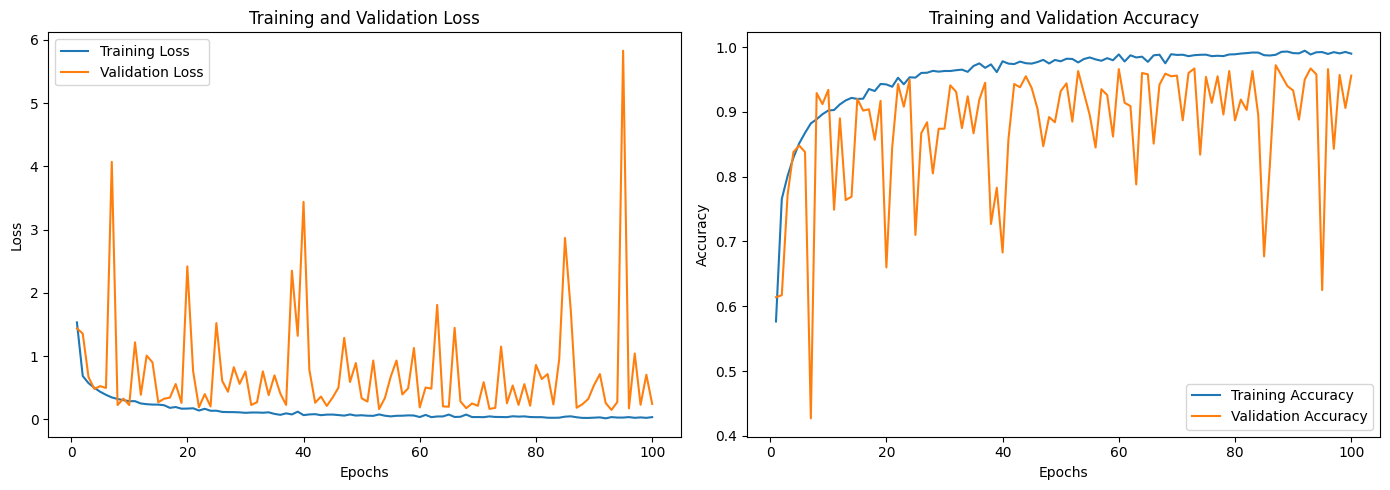

In [6]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


THE OPTIMIZED CODE IS BELOW WITH EARLY STOPPPING AND RATE SCHEDULING

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

# Define the ImprovedPlantVillageCNN model here if not already defined
class ImprovedPlantVillageCNN(nn.Module):
    def __init__(self):
        super(ImprovedPlantVillageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedPlantVillageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # added weight decay for regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# Training the model
num_epochs = 50  # increased epochs for demonstration
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
            pbar.update(1)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_correct / running_total)

    # Validate the model every epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validating', unit='batch') as pbar_val:
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                pbar_val.update(1)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

    # Step the scheduler
    scheduler.step(val_losses[-1])

    # Check for early stopping
    if early_stopping.step(val_losses[-1]):
        print("Early stopping triggered")
        break

# Save the trained model
model_save_path = 'Optimized_plant_village_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


c:\Users\User\anaconda3\envs\tomato-disease\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Validating: 100%|██████████| 16/16 [00:01<00:00, 13.22batch/s]


Epoch [1/50], Train Loss: 1.4812, Val Loss: 1.7651, Train Accuracy: 0.5744, Val Accuracy: 0.5230


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.19batch/s]


Epoch [2/50], Train Loss: 0.6480, Val Loss: 0.6301, Train Accuracy: 0.7733, Val Accuracy: 0.8020


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.30batch/s]


Epoch [3/50], Train Loss: 0.5423, Val Loss: 0.4929, Train Accuracy: 0.8135, Val Accuracy: 0.8280


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.13batch/s]


Epoch [4/50], Train Loss: 0.4486, Val Loss: 2.0956, Train Accuracy: 0.8424, Val Accuracy: 0.5140


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.73batch/s]


Epoch [5/50], Train Loss: 0.3905, Val Loss: 0.5037, Train Accuracy: 0.8651, Val Accuracy: 0.8440


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.86batch/s]


Epoch [6/50], Train Loss: 0.3454, Val Loss: 0.4848, Train Accuracy: 0.8817, Val Accuracy: 0.8690


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.49batch/s]


Epoch [7/50], Train Loss: 0.3369, Val Loss: 0.4831, Train Accuracy: 0.8857, Val Accuracy: 0.8580


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.12batch/s]


Epoch [8/50], Train Loss: 0.3036, Val Loss: 0.5805, Train Accuracy: 0.8944, Val Accuracy: 0.8370


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.37batch/s]


Epoch [9/50], Train Loss: 0.2544, Val Loss: 0.9015, Train Accuracy: 0.9085, Val Accuracy: 0.7570


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.11batch/s]


Epoch [10/50], Train Loss: 0.2612, Val Loss: 0.5118, Train Accuracy: 0.9115, Val Accuracy: 0.8410


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.56batch/s]


Epoch [11/50], Train Loss: 0.2545, Val Loss: 0.5277, Train Accuracy: 0.9119, Val Accuracy: 0.8570


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.71batch/s]


Epoch [12/50], Train Loss: 0.1611, Val Loss: 0.1443, Train Accuracy: 0.9461, Val Accuracy: 0.9530


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.51batch/s]


Epoch [13/50], Train Loss: 0.1159, Val Loss: 0.1314, Train Accuracy: 0.9599, Val Accuracy: 0.9580


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.47batch/s]


Epoch [14/50], Train Loss: 0.1086, Val Loss: 0.1198, Train Accuracy: 0.9642, Val Accuracy: 0.9560


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.73batch/s]


Epoch [15/50], Train Loss: 0.0999, Val Loss: 0.1350, Train Accuracy: 0.9662, Val Accuracy: 0.9510


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.54batch/s]


Epoch [16/50], Train Loss: 0.0957, Val Loss: 0.1361, Train Accuracy: 0.9673, Val Accuracy: 0.9530


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.95batch/s]


Epoch [17/50], Train Loss: 0.0947, Val Loss: 0.1272, Train Accuracy: 0.9668, Val Accuracy: 0.9550


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.03batch/s]


Epoch [18/50], Train Loss: 0.0929, Val Loss: 0.1198, Train Accuracy: 0.9686, Val Accuracy: 0.9570


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.24batch/s]


Epoch [19/50], Train Loss: 0.0831, Val Loss: 0.1149, Train Accuracy: 0.9707, Val Accuracy: 0.9580


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.96batch/s]


Epoch [20/50], Train Loss: 0.0816, Val Loss: 0.1157, Train Accuracy: 0.9720, Val Accuracy: 0.9620


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.16batch/s]


Epoch [21/50], Train Loss: 0.0763, Val Loss: 0.1164, Train Accuracy: 0.9738, Val Accuracy: 0.9590


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.41batch/s]


Epoch [22/50], Train Loss: 0.0756, Val Loss: 0.1145, Train Accuracy: 0.9730, Val Accuracy: 0.9620


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.17batch/s]


Epoch [23/50], Train Loss: 0.0754, Val Loss: 0.1141, Train Accuracy: 0.9740, Val Accuracy: 0.9580


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.44batch/s]


Epoch [24/50], Train Loss: 0.0824, Val Loss: 0.1113, Train Accuracy: 0.9707, Val Accuracy: 0.9540


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.97batch/s]


Epoch [25/50], Train Loss: 0.0735, Val Loss: 0.1158, Train Accuracy: 0.9746, Val Accuracy: 0.9560


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.80batch/s]


Epoch [26/50], Train Loss: 0.0735, Val Loss: 0.1128, Train Accuracy: 0.9761, Val Accuracy: 0.9620


Validating: 100%|██████████| 16/16 [00:01<00:00, 14.05batch/s]


Epoch [27/50], Train Loss: 0.0715, Val Loss: 0.1105, Train Accuracy: 0.9759, Val Accuracy: 0.9570


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.62batch/s]


Epoch [28/50], Train Loss: 0.0739, Val Loss: 0.1137, Train Accuracy: 0.9745, Val Accuracy: 0.9550


Validating: 100%|██████████| 16/16 [00:01<00:00, 13.80batch/s]


Epoch [29/50], Train Loss: 0.0740, Val Loss: 0.1136, Train Accuracy: 0.9749, Val Accuracy: 0.9600
Early stopping triggered


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 1493120 vs 1493016

ValueError: x and y must have same first dimension, but have shapes (50,) and (29,)

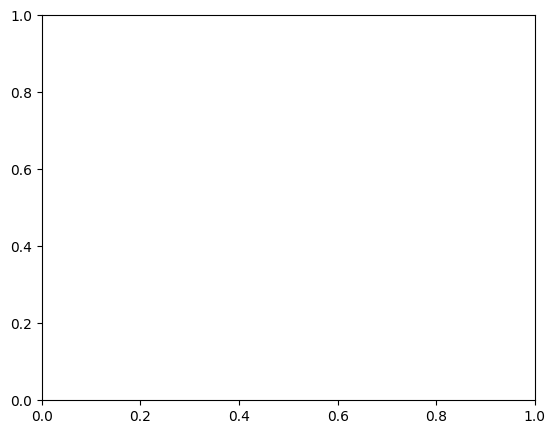

In [19]:

# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [6]:
# Define the improved CNN architecture
class PlantVillageCNN(nn.Module):
    def __init__(self):
        super(PlantVillageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [7]:

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Initialize the model, criterion, and optimizer
model = PlantVillageCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0

# Lists to store loss and accuracy for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})
            pbar.update(1)

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validate the model every epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc='Validating', unit='batch') as pbar_val:
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()
                pbar_val.update(1)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))



Using device: cuda


Validating:  56%|█████▋    | 9/16 [00:00<00:00, 11.98batch/s]


FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/tomato/val\\Tomato___Spider_mites Two-spotted_spider_mite\\Tomato___Spider_mites Two-spotted_spider_mite_original_00fa99e8-2605-4d72-be69-98277587d84b___Com.G_SpM_FL 1453.JPG_5a4912ea-1fce-46e0-a929-f5b66622fc78.JPG'

In [ ]:

# Save the final model
model_save_path = 'plant_village_cnn_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()
